# Facebool Prophet

In this project we will try to predict the number of people who will need shelter.

Intuitively we can imagine that the number of people who need a refuge depends on the weather, therefore on the season, on the holidays: so it seems like a perfect problem to solve with Facebook Prophet.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The framework that typically applies to time series analysis is the structural time series which simply means decomposing the time series into trend, seasonality, and exogenus events.

Facebook Prophet follows a similar approach. 

The formula is: $$y(t) = c(t) + s(t) + h(t) + x(t) + ε$$ 

How to read this formula:

- c(t) is the trend component 
- s(t) is the sesosonality 

then we have the exogenus events that are split into two:

- h(t) is the Holiday Effects
- x(t) is the external regressors that can be any other event

finally we have

- ε is the error term, everithing that can not be explained by the model

Importing data and libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

Previewing first five rows and general information of data.


In [2]:
df = pd.read_csv('DHS_Daily_Report_2020.csv')

In [3]:
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/1/2014,50689,0,0,0,2.17
1,1/2/2014,50797,0,0,0,2.51
2,1/3/2014,50954,0,0,0,-6.35
3,1/4/2014,50957,0,0,0,-1.27
4,1/5/2014,50957,0,0,0,7.18


Preview of the Time Series

<AxesSubplot:>

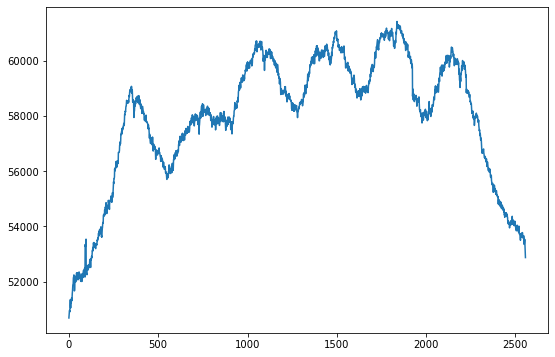

In [4]:
df['Total Individuals in Shelter'].plot(figsize=(9,6))

Transform date variable in the formt required by Facebook Prophet: 'Year' - 'Month' - 'Day'

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")

In [6]:
df['Date'].head()

0   2014-01-01
1   2014-01-02
2   2014-01-03
3   2014-01-04
4   2014-01-05
Name: Date, dtype: datetime64[ns]

Rename date variable as 'ds' and the dependent variable as 'y'. Also this step is mandatory to use the model

In [7]:
df = df.rename(columns = {'Date':'ds', 'Total Individuals in Shelter': 'y'})

### Preparing the Dynamic Holidays

With Facebook prophet we can specify the day the holiday but also how many days before and after we think the holiday has an effect on the variable we want to predict. We will use all the holidays we have in the data as Dynamic Holiday but they can also be considered exogenus events.

Easter

In [8]:
easter_dates = df[df['Easter'] == 1]['ds']
easter = pd.DataFrame({'holiday':'easter',
                      'ds': easter_dates,
                      'lower_window': -2,
                      'upper_window': 2})

Thanksgiving

In [9]:
tk_dates = df[df['Thanksgiving'] == 1]['ds']
tk = pd.DataFrame({'holiday':'tk',
                      'ds': tk_dates,
                      'lower_window': -5,
                      'upper_window': 2})

Christmas

In [10]:
ch_dates = df[df['Christmas'] == 1]['ds']
ch = pd.DataFrame({'holiday':'ch',
                      'ds': ch_dates,
                      'lower_window': -7,
                      'upper_window': 5})

Creating a new DataFrame with only the Dynamic Holiday

In [11]:
holidays = pd.concat([easter, tk, ch])

Preparing the DataFrame to train the model

In [12]:
df = df.drop(columns=['Easter', 'Thanksgiving', 'Christmas'])

In [13]:
df.head()

,ds,y,Temperature
0,2014-01-01,50689,2.17
1,2014-01-02,50797,2.51
2,2014-01-03,50954,-6.35
3,2014-01-04,50957,-1.27
4,2014-01-05,50957,7.18


### Spliting the Time Serie in training and test set

We want to make a forecast for a month, so we will use 31 days to test the model and the rest to train it. The number of days used to test the model must be equal to the period we want to forecast

In [14]:
test_days = 31

In [15]:
training_set = df.iloc[:-test_days,:]

In [16]:
test_set = df.iloc[-test_days:,:]

## Training the model 

Facebook Prophet has many parameters that can be selected, some of the most important are:

- Growth which can be 'linear' or 'logistic' depending on whether the series grew linearly or exponentially
- Holiday that is the DataFrame we prepared with the Dynamic Holiday
- Seasonality that can be yearly, weekly or daily ('True' or 'False') for our daily data we use only weekly and yearly seasonality 
- Seasonality_mode can be 'multiplicative' or 'additive'
- Seasonality_prior_scale is a number the higher the stronger is the seasonality
- Holiday_prior_scale the higher the value the higher the holiday effect
- Changepoint_prior_scale rappresent how easly the trend can change

Training the model

In [17]:
model = Prophet(growth='linear', yearly_seasonality=True,
    weekly_seasonality=True,daily_seasonality=False, holidays=holidays, seasonality_mode='multiplicative',seasonality_prior_scale=10, holidays_prior_scale=10, changepoint_prior_scale=0.05)

Add a regressor (exogenus events)

In [18]:
model.add_regressor('Temperature')

Fit the model on the training set

In [19]:
model.fit(training_set)

13:43:23 - cmdstanpy - INFO - Chain [1] start processing
13:43:24 - cmdstanpy - INFO - Chain [1] done processing


### Regressor Coefficient


In [20]:
from prophet.utilities import regressor_coefficients

In [21]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Temperature,multiplicative,14.960234,-0.000185,-0.000185,-0.000185


The coeficient is negative and multiplicative that means when the temperature increases by one degree, the number of people seeking refuge decreases by 0.0185%

### Forecasting

Creating a future DataFrame specifying the period for which we want to make predictions

In [22]:
future = model.make_future_dataframe(periods=test_days, freq='D')

future = pd.concat([future, df.iloc[:,2:]], axis=1)

In [23]:
forecast = model.predict(future)

In [24]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Temperature,Temperature_lower,Temperature_upper,ch,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,50031.484090,50440.742510,51213.795114,50031.484090,50031.484090,0.002371,0.002371,0.002371,0.0,...,0.000704,0.000704,0.000704,0.012542,0.012542,0.012542,0.0,0.0,0.0,50812.810178
1,2014-01-02,50053.213082,50425.925682,51186.240332,50053.213082,50053.213082,0.002308,0.002308,0.002308,0.0,...,0.000576,0.000576,0.000576,0.012770,0.012770,0.012770,0.0,0.0,0.0,50836.776628
2,2014-01-03,50074.942074,50494.862022,51254.830900,50074.942074,50074.942074,0.003950,0.003950,0.003950,0.0,...,-0.000830,-0.000830,-0.000830,0.013060,0.013060,0.013060,0.0,0.0,0.0,50885.157073
3,2014-01-04,50096.671066,50484.651801,51217.539488,50096.671066,50096.671066,0.003009,0.003009,0.003009,0.0,...,-0.001544,-0.001544,-0.001544,0.013409,0.013409,0.013409,0.0,0.0,0.0,50841.794771
4,2014-01-05,50118.400057,50516.067858,51288.256668,50118.400057,50118.400057,0.001442,0.001442,0.001442,0.0,...,0.000149,0.000149,0.000149,0.013812,0.013812,0.013812,0.0,0.0,0.0,50890.368885


### Accuracy Assessment

In [25]:
predictions = forecast['yhat'][-test_days:]


In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(test_set['y'], predictions))

1331.4817040947248

In [28]:
test_set['y'].mean()

53543.58064516129

In [29]:
test_set['y'].std()

206.13826657425003

The model has a Root Mean square error of about 1331. It means that the model on average overestimates or underestimates the number of people who need shelter by 1331 people which is a relatively small numeber compared to average numebr of people that need the shelter daily. 

### Visualization of the Time Serie

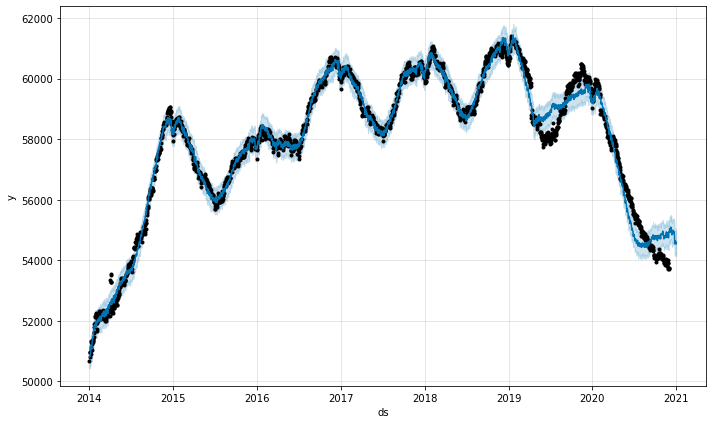

In [30]:
model.plot(forecast);

The black line represents the true values while the blue line those predicted by the model, with the lighter area representing the confidence interval.

### Visualizattion of the components 

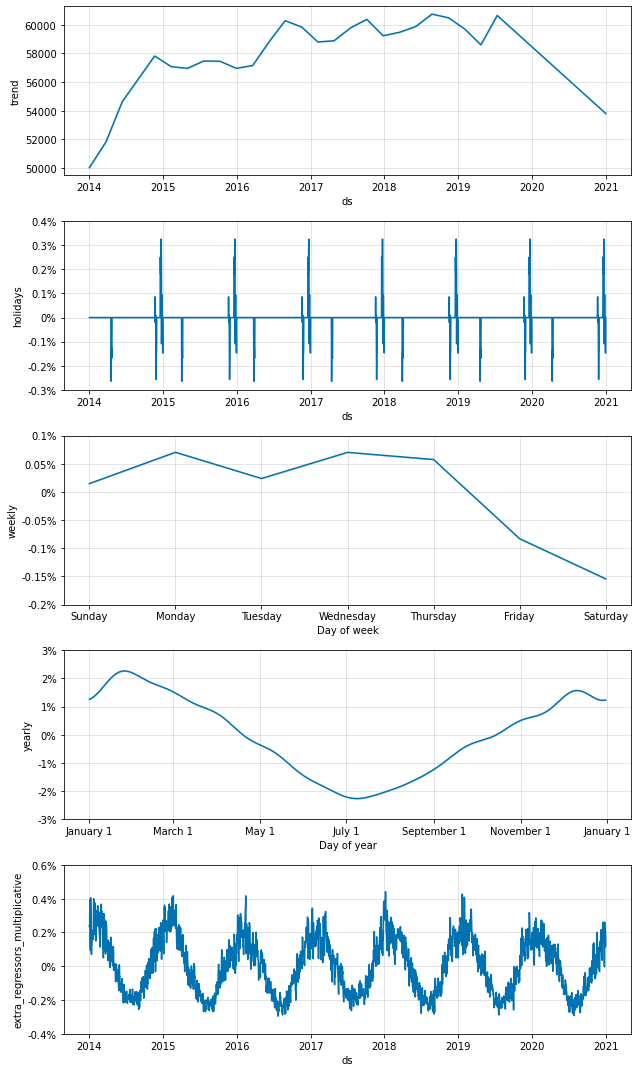

In [31]:
model.plot_components(forecast);

From the visualization above we can draw some interesting information. For example, on Easter days, the number of people who need shelter drops by about 0.3%. The same goes for Thanksgiving Day and Christmas but it increases by about the same amount in the days immediately following.

It should also be noted that during the weekend the number of people seeking shelter drops by around 0.2%.

### Cross-validation

Cross-validation is a technique for assessing how the results of a statistical analysis will generalize to an independent data set.

Facebook Prophet includes functionality for time series cross validation.

In [32]:
from prophet.diagnostics import cross_validation

In [33]:
df_cv = cross_validation(model=model, horizon='31 days', initial='1500 days', parallel='processes')

In [34]:
np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

772.9432827369083

The Root Mean Squared Error of cross-validation is smaller than we calculated previously. This actually means that the model is better than it appeared and should perform well even on previously unseen data

### Parameter tuning

Parameter tuning help to chose a set of optimal parameters for the model

In [35]:
from sklearn.model_selection import ParameterGrid

In [36]:
param_grid = {'seasonality_prior_scale':[5,10,20], 'holidays_prior_scale':[5,10,20], 'changepoint_prior_scale':[0.01, 0.05, 0.1]}

In [37]:
grid = ParameterGrid(param_grid)

In [38]:
rmse = []
for params in grid:
    # model
    model = Prophet(growth='linear', yearly_seasonality=True,
    weekly_seasonality=True,daily_seasonality=False, holidays=holidays,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=params['seasonality_prior_scale'], 
                    holidays_prior_scale=params['holidays_prior_scale'],
                    changepoint_prior_scale=params['changepoint_prior_scale'])
    model.add_regressor('Temperature')
    model.fit(training_set)
    df_cv = cross_validation(model=model, horizon='31 days', initial='1500 days', parallel='processes')
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    rmse.append(error)

13:44:51 - cmdstanpy - INFO - Chain [1] start processing
13:44:53 - cmdstanpy - INFO - Chain [1] done processing
13:46:18 - cmdstanpy - INFO - Chain [1] start processing
13:46:20 - cmdstanpy - INFO - Chain [1] done processing
13:47:43 - cmdstanpy - INFO - Chain [1] start processing
13:47:45 - cmdstanpy - INFO - Chain [1] done processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] done processing
13:50:31 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:51:52 - cmdstanpy - INFO - Chain [1] start processing
13:51:54 - cmdstanpy - INFO - Chain [1] done processing
13:53:21 - cmdstanpy - INFO - Chain [1] start processing
13:53:23 - cmdstanpy - INFO - Chain [1] done processing
13:54:43 - cmdstanpy - INFO - Chain [1] start processing
13:54:45 - cmdstanpy - INFO - Chain [1] done processing
13:56:22 - cmdstanpy - INFO - Chain [1] start processing
13:56:24 - cmdstanpy - INFO - Chain [1]

Selecting the best parameters for our model

In [39]:
best_params = grid[np.argmin(rmse)]
best_params

{'seasonality_prior_scale': 5,
 'holidays_prior_scale': 10,
 'changepoint_prior_scale': 0.1}

Training a new model with the new parameters

In [40]:
model = Prophet(growth='linear', yearly_seasonality=True,
    weekly_seasonality=True,daily_seasonality=False, holidays=holidays, seasonality_mode='multiplicative',seasonality_prior_scale=10, holidays_prior_scale=20, changepoint_prior_scale=0.1)

Regressor coefficient

In [41]:
model.add_regressor('Temperature')
model.fit(training_set)
    

14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:06 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Temperature,multiplicative,14.960234,-0.000191,-0.000191,-0.000191


The coeficient is still negative and multiplicative. The number of people seeking refuge decreases by 0.0191%

Forecasting

In [43]:
future = model.make_future_dataframe(periods=test_days, freq='D')

future = pd.concat([future, df.iloc[:,2:]], axis=1)
forecast = model.predict(future)

Accuracy Assessment

In [46]:
predictions = forecast['yhat'][-test_days:]


In [47]:
np.sqrt(mean_squared_error(test_set['y'], predictions))

1316.7989645455416

The new model has only slightly improved its accuracy

**Visualization of the Time Serie**

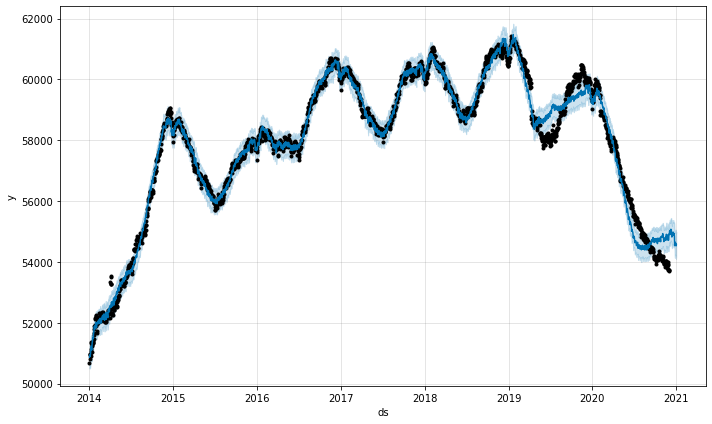

In [44]:
model.plot(forecast);

**Visualization of the components**

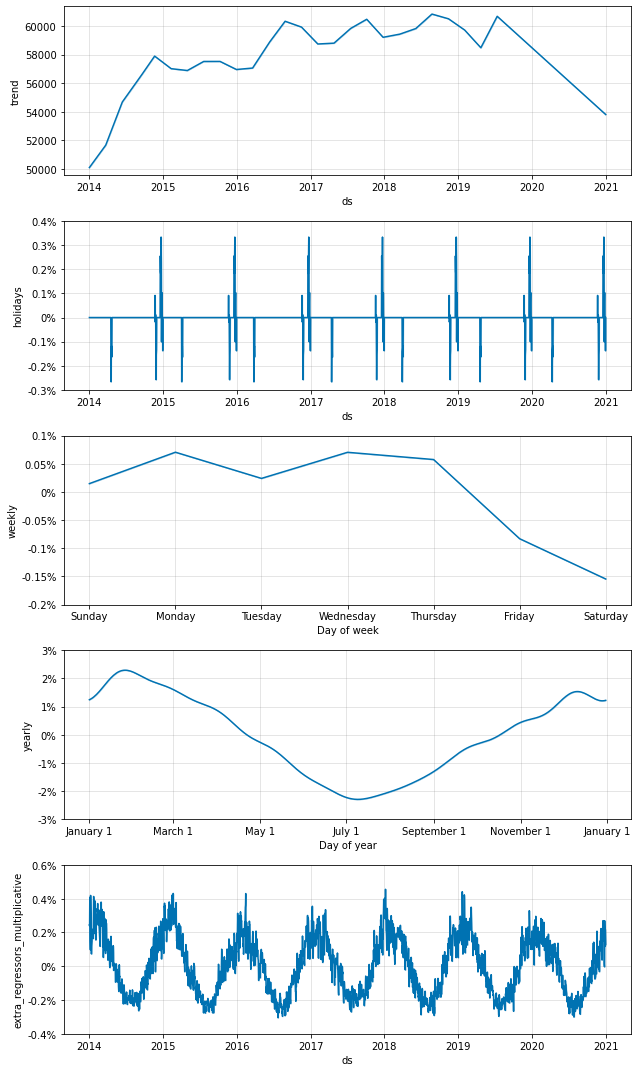

In [45]:
model.plot_components(forecast);